In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
print(os.environ.get("ANTHROPIC_API_KEY"))

In [5]:
os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass(
        prompt="Enter your LangSmith API key (optional): "
    )
if "LANGSMITH_PROJECT" not in os.environ:
    os.environ["LANGSMITH_PROJECT"] = getpass.getpass(
        prompt='Enter your LangSmith Project Name (default = "default"): '
    )
    if not os.environ.get("LANGSMITH_PROJECT"):
        os.environ["LANGSMITH_PROJECT"] = "default"

In [6]:
from langgraph.prebuilt import create_react_agent

def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

agent = create_react_agent("anthropic:claude-3-7-sonnet-latest", tools=[search])
agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='51bcd83c-c7e7-43d0-86f4-534ba6e14286'),
  AIMessage(content=[{'text': 'I can help you check the current weather in San Francisco. Let me search for that information for you.', 'type': 'text'}, {'id': 'toolu_01SbQASJyc5xtnXSM8ZmKcYN', 'input': {'query': 'current weather in San Francisco'}, 'name': 'search', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01QFqH5dYdmpNTBKm6xb41su', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 377, 'output_tokens': 77, 'server_tool_use': None}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run--31c0dc38-267c-44e4-ba92-e09142e40ffb-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in San Francisco'}, 'id': 'toolu_01SbQASJyc5xtnXSM8ZmKcYN', 'type': 'tool_call'}], usag

In [7]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


In [8]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [11]:
# 添加边
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 构建图
graph = graph_builder.compile()

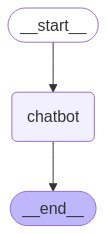

In [12]:
# 画图
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
graph.invoke({"messages": [{"role": "user", "content": "what is the weather in sf"}]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='314b02ef-2202-4cc0-9604-d7117fa44c27'),
  AIMessage(content="I am not able to provide real-time weather information. To get current weather conditions in San Francisco, I recommend:\n\n1. Checking a weather website or app like Weather.com or AccuWeather\n2. Visiting the National Weather Service website\n3. Looking up local San Francisco news stations' weather reports", additional_kwargs={}, response_metadata={'id': 'msg_0125KcbxJTXFxcvA1Qyg6SVo', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 69, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--ce1b66f4-7b1b-46cc-82d0-cb87586250e2-0', usage_metadata={'input_tokens': 13, 'output_tokens': 69, 'total_tokens': 82, 'input_token_details': {'cache_read

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: LangGraph is a Python library built on top of LangChain that helps developers create structured, stateful applications using Large Language Models (LLMs). It's particularly useful for building conversational AI applications that require maintaining state and following specific workflows.

Key features and concepts of LangGraph include:

1. State Machines: It allows you to create state machines to manage conversation flows and application logic

2. Graph-based Structure: Uses directed graphs to represent different states and transitions in your application

3. Integration with LangChain: Built to work seamlessly with LangChain's components and abstractions

4. State Management: Helps maintain conversation context and state across interactions

5. Workflow Definition: Enables defining clear workflows for complex conversational scenarios

The library is particularly useful for:
- Building multi-step conversations
- Creating interactive ag